In [ ]:
!pip install pandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/temperature_device_failure (1).csv")

In [ ]:
df

,timestamp,value
0,7/4/2013 0:00,69.880835
1,7/4/2013 1:00,71.220227
2,7/4/2013 2:00,70.877805
3,7/4/2013 3:00,68.959400
4,7/4/2013 4:00,69.283551
...,...,...
7262,5/28/2014 11:00,72.370206
7263,5/28/2014 12:00,72.172956
7264,5/28/2014 13:00,72.046565
7265,5/28/2014 14:00,71.825226


In [ ]:
df.info(())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [ ]:
df.columns

Index(['timestamp', 'value'], dtype='object')

# Ploting the time series

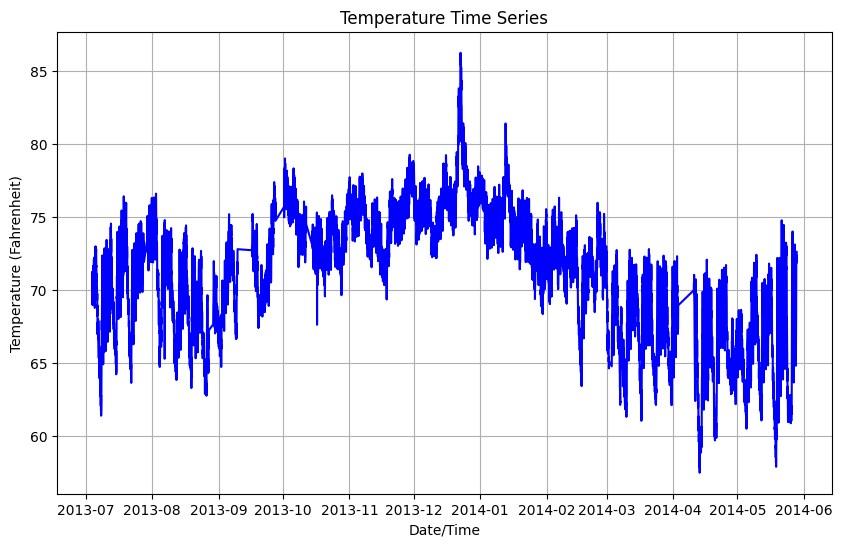

In [ ]:
# Convert the date/time column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['value'], color='blue')
plt.title('Temperature Time Series')
plt.xlabel('Date/Time')
plt.ylabel('Temperature (Fahrenheit)')
plt.grid(True)
plt.show()


#categorize day and night and creating the 'dtcat' feature




In [ ]:
# Extract day of the week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Extract hour of the day
df['hour_of_day'] = df['timestamp'].dt.hour

# Define a function to categorize day and night
def categorize_time(row):
    if row['day_of_week'] < 5:  # Weekday
        if 6 <= row['hour_of_day'] < 18:  # Daytime
            return 'Weekday Day'
        else:  # Nighttime
            return 'Weekday Night'
    else:  # Weekend
        if 6 <= row['hour_of_day'] < 18:  # Daytime
            return 'Weekend Day'
        else:  # Nighttime
            return 'Weekend Night'

# Apply the function to create the 'dtcat' feature
df['dtcat'] = df.apply(categorize_time, axis=1)

# Print the first few rows to verify
print(df.head())


            timestamp      value  day_of_week  hour_of_day          dtcat
0 2013-07-04 00:00:00  69.880835            3            0  Weekday Night
1 2013-07-04 01:00:00  71.220227            3            1  Weekday Night
2 2013-07-04 02:00:00  70.877805            3            2  Weekday Night
3 2013-07-04 03:00:00  68.959400            3            3  Weekday Night
4 2013-07-04 04:00:00  69.283551            3            4  Weekday Night


#Drop intermediate columns if needed

In [ ]:
# Function to categorize time of the day
def categorize_time(hour):
    if 7 <= hour < 19:
        return 'Day'
    else:
        return 'Night'

# Function to categorize day of the week
def categorize_day(day):
    if day < 5:  # Monday to Friday
        return 'Weekday'
    else:
        return 'Weekend'

# Extract day of the week and hour of the day
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour

# Create 'dtcat' feature
df['time_category'] = df['hour'].apply(categorize_time)
df['day_category'] = df['dayofweek'].apply(categorize_day)
df['dtcat'] = df['day_category'] + ' ' + df['time_category']

# Drop intermediate columns if needed
df.drop(['dayofweek', 'hour', 'time_category', 'day_category'], axis=1, inplace=True)

# Print the updated dataframe
print(df.head())


            timestamp      value          dtcat
0 2013-07-04 00:00:00  69.880835  Weekday Night
1 2013-07-04 01:00:00  71.220227  Weekday Night
2 2013-07-04 02:00:00  70.877805  Weekday Night
3 2013-07-04 03:00:00  68.959400  Weekday Night
4 2013-07-04 04:00:00  69.283551  Weekday Night


# Performing K-Means clustering, plotting elbow curve & silhouette scores

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['value']])

# Initialize lists to store inertia and silhouette scores
inertia = []
silhouette_scores = []

# Range of K values to test
k_values = range(1, 21)

# Perform K-Means clustering for each value of K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Set n_init explicitly
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))


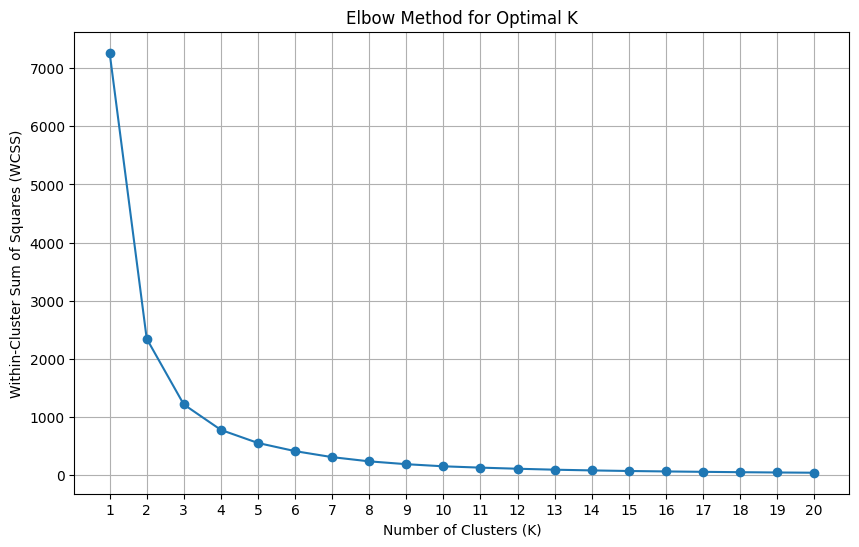

In [ ]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

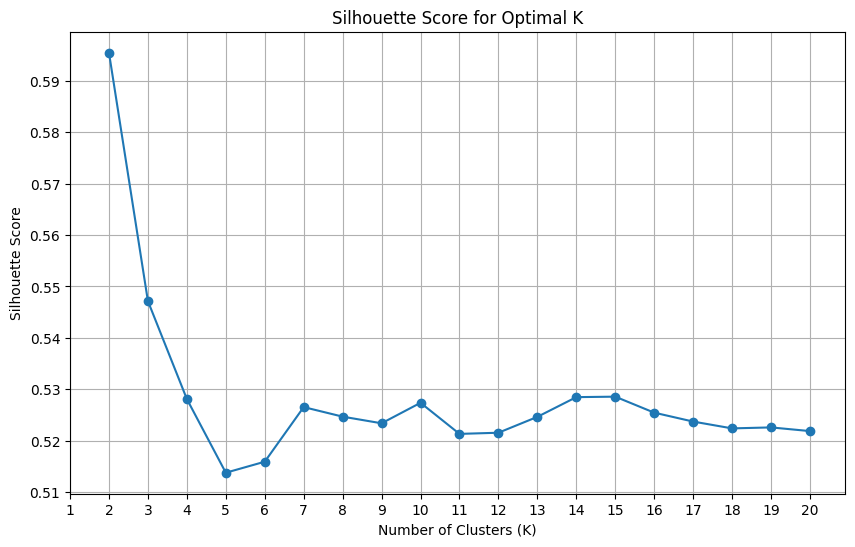

In [ ]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

#Applying EllipticEnvelope algorithm & Visualizing anomalies for each category

In [ ]:
from sklearn.covariance import EllipticEnvelope

# Initialize dictionary to store anomalies for each category
anomalies_by_category = {}

# Separate data into categories based on 'dtcat'
categories = df['dtcat'].unique()
for category in categories:
    category_data = df[df['dtcat'] == category]['value'].values.reshape(-1, 1)

    # Apply EllipticEnvelope algorithm
    envelope = EllipticEnvelope(contamination=0.05)  # Assuming 5% contamination
    envelope.fit(category_data)

    # Predict outliers/anomalies
    anomalies = envelope.predict(category_data)
    anomalies_indices = [i for i, anomaly in enumerate(anomalies) if anomaly == -1]
    anomalies_values = category_data[anomalies_indices]

    # Store anomalies for each category
    anomalies_by_category[category] = anomalies_values

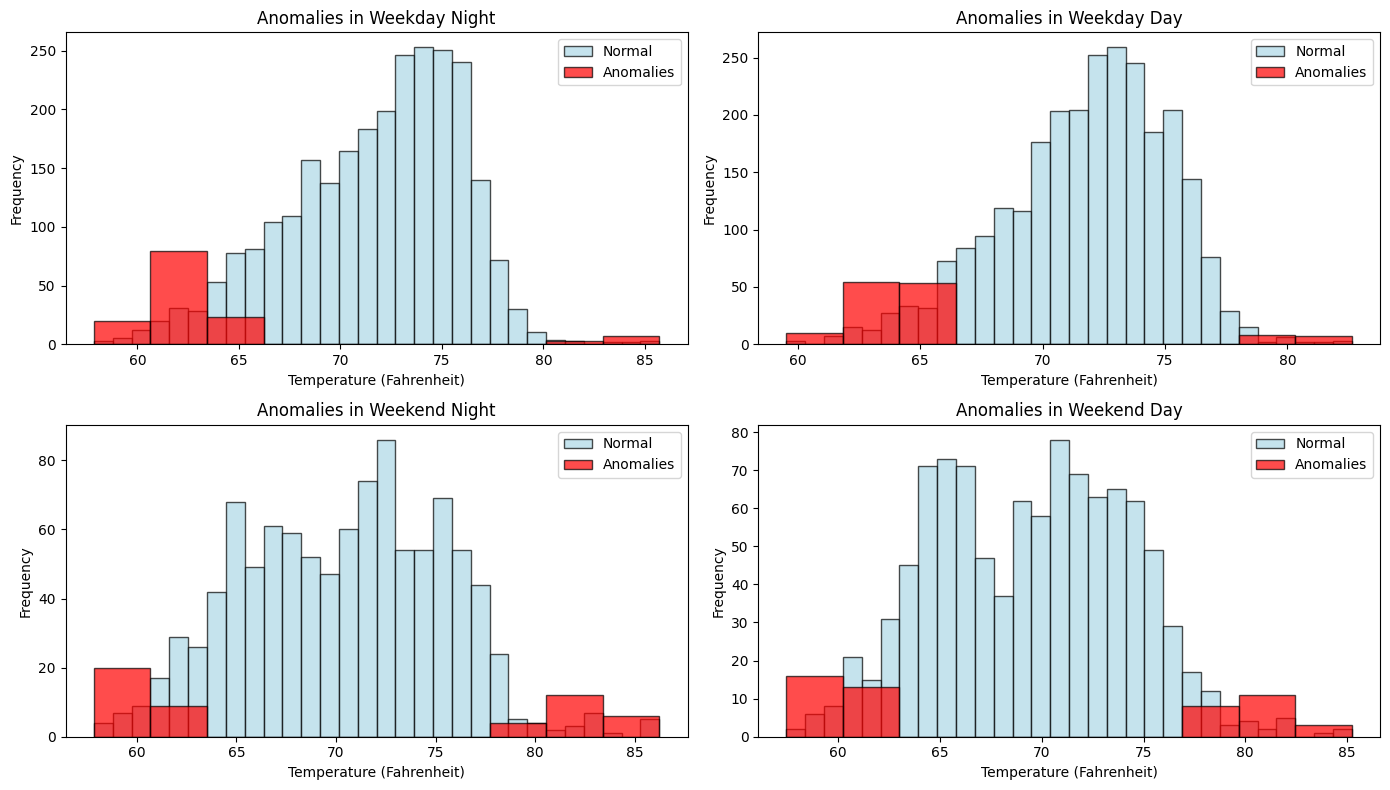

In [ ]:
# Visualize anomalies for each category
plt.figure(figsize=(14, 8))
for i, category in enumerate(categories, start=1):
    plt.subplot(2, 2, i)
    plt.hist(df[df['dtcat'] == category]['value'], bins=30, color='lightblue', edgecolor='black', alpha=0.7, label='Normal')
    plt.hist(anomalies_by_category[category], bins=10, color='red', edgecolor='black', alpha=0.7, label='Anomalies')
    plt.title(f'Anomalies in {category}')
    plt.xlabel('Temperature (Fahrenheit)')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

**counts of anomalies for each category**

In [ ]:
# Initialize dictionary to store counts of anomalies for each category
anomaly_counts = {}

# Count anomalies for each category
for category in categories:
    anomaly_counts[category] = len(anomalies_by_category[category])

# Print anomaly counts for each category
for category, count in anomaly_counts.items():
    print(f'Anomalies in {category}: {count}')

Anomalies in Weekday Night: 132
Anomalies in Weekday Day: 132
Anomalies in Weekend Night: 51
Anomalies in Weekend Day: 51


#Applying IsolationForest algorithm, Visualizing anomalies for each category



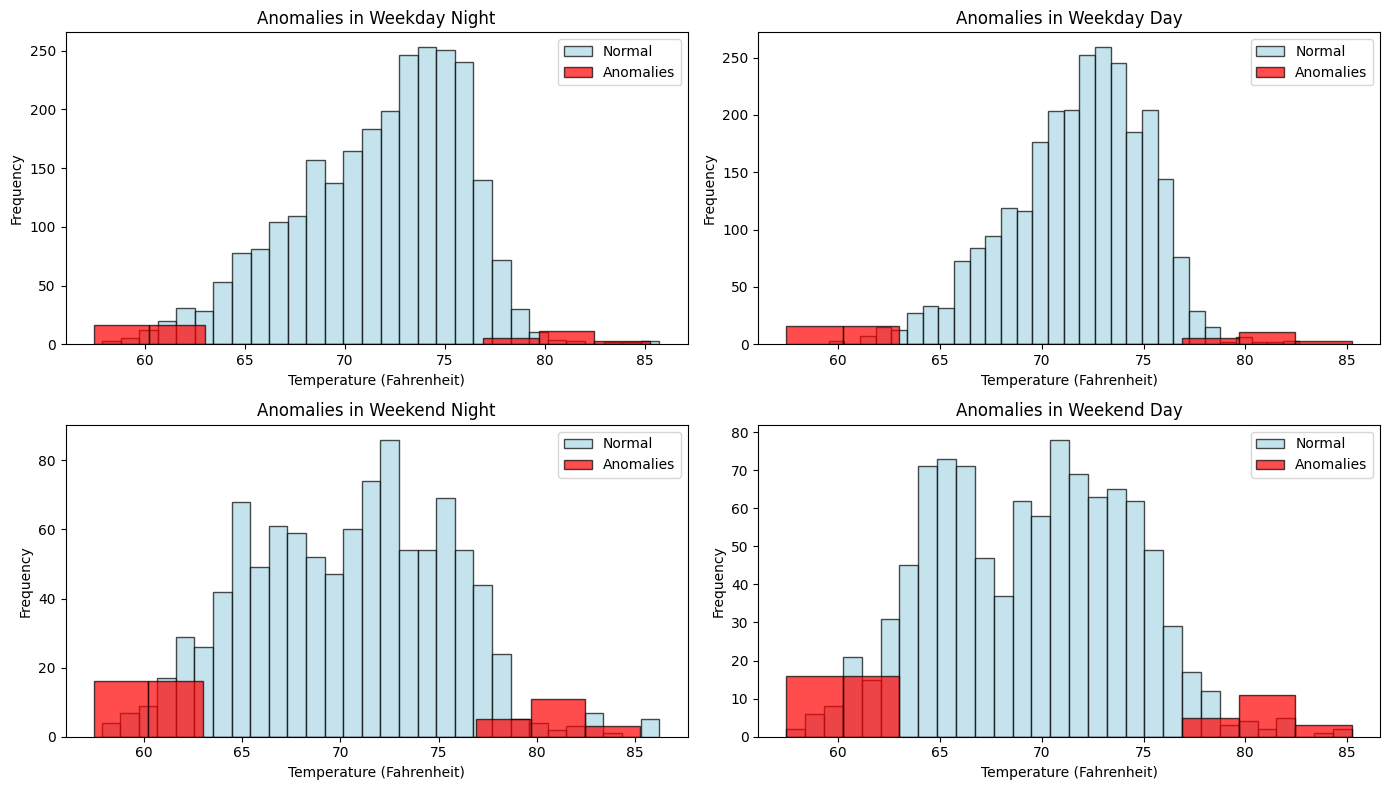

In [ ]:
from sklearn.ensemble import IsolationForest


# Apply IsolationForest algorithm
isolation_forest = IsolationForest(contamination=0.05)  # Assuming 5% contamination
isolation_forest.fit(category_data)

# Predict outliers/anomalies
anomalies = isolation_forest.predict(category_data)
anomalies_indices = [i for i, anomaly in enumerate(anomalies) if anomaly == -1]
anomalies_values = category_data[anomalies_indices]

# Store anomalies for each category
anomalies_by_category = {}
for category in categories:
    anomalies_by_category[category] = anomalies_values

# Visualize anomalies for each category
plt.figure(figsize=(14, 8))
for i, category in enumerate(categories, start=1):
    plt.subplot(2, 2, i)
    plt.hist(df[df['dtcat'] == category]['value'], bins=30, color='lightblue', edgecolor='black', alpha=0.7, label='Normal')
    plt.hist(anomalies_by_category[category], bins=10, color='red', edgecolor='black', alpha=0.7, label='Anomalies')
    plt.title(f'Anomalies in {category}')
    plt.xlabel('Temperature (Fahrenheit)')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()



**counts of anomalies for each category**

In [ ]:
# Initialize dictionary to store counts of anomalies for each category
anomaly_counts = {}

# Count anomalies for each category
for category in categories:
    anomaly_counts[category] = len(anomalies_by_category[category])

# Print anomaly counts for each category
for category, count in anomaly_counts.items():
    print(f'Anomalies in {category}: {count}')

Anomalies in Weekday Night: 51
Anomalies in Weekday Day: 51
Anomalies in Weekend Night: 51
Anomalies in Weekend Day: 51


#  Which of the two (2) models performs better on detecting anomalies?

 From the visual inspection of the histograms, both algorithms seem to perform reasonably well in detecting anomalies. However, Isolation Forest had a slight edge due to its ability to handle non-linear relationships and complex data distributions.